In [21]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [22]:
from tensorflow.keras.optimizers import SGD

In [23]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Base Path for all files
data_dir = './train_images'

In [25]:
# ImageDataGenerator for Data Augmentation
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.2,
                                zoom_range=0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                rotation_range=40,
                                brightness_range=[0.8, 1.2]
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),
    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 9371 images belonging to 10 classes.
Found 1036 images belonging to 10 classes.


In [5]:
# Initializing MobileNetV2 (pretrained) model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Fine-tune the model: Set first 100 layers as non-trainable
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Adding custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes
])



9406464/9406464 [==============================] - 8s 1us/step


In [10]:
# Optimizer without the deprecated 'decay' parameter
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compiling the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [11]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [12]:
# Training variables
batch_size = 32
epochs = 50

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [13]:
# Calculate class weights for imbalance handling
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Calculating steps per epoch and validation steps
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size


In [14]:
# Filepath to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Callbacks: ModelCheckpoint and ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    verbose=1, 
    min_lr=1e-6
)
callbacks_list = [checkpoint, lr_schedule]

# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=callbacks_list
)

Epoch 1/50


292/292 [==============================] - ETA: 0s - loss: 8.5782 - accuracy: 0.4303
Epoch 1: val_accuracy improved from -inf to 0.25781, saving model to .\model_01-0.26.h5
292/292 [==============================] - 331s 1s/step - loss: 8.5782 - accuracy: 0.4303 - val_loss: 7.8954 - val_accuracy: 0.2578 - lr: 0.0100
Epoch 2/50
292/292 [==============================] - ETA: 0s - loss: 3.2963 - accuracy: 0.6315
Epoch 2: val_accuracy did not improve from 0.25781
292/292 [==============================] - 322s 1s/step - loss: 3.2963 - accuracy: 0.6315 - val_loss: 6.3877 - val_accuracy: 0.2090 - lr: 0.0100
Epoch 3/50
292/292 [==============================] - ETA: 0s - loss: 1.6349 - accuracy: 0.7044
Epoch 3: val_accuracy improved from 0.25781 to 0.30273, saving model to .\model_03-0.30.h5
292/292 [==============================] - 325s 1s/step - loss: 1.6349 - accuracy: 0.7044 - val_loss: 4.9443 - val_accuracy: 0.3027 - lr: 0.0100
Epoch 4/50
292/292 [=========================

In [16]:
import matplotlib.pyplot as plt

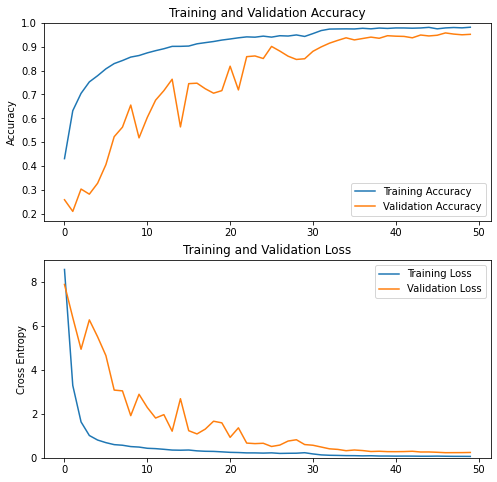

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

33/33 [==============================] - 18s 546ms/step - loss: 0.2403 - accuracy: 0.9527
test accuracy :  0.9527027010917664


In [22]:
from tensorflow.keras.preprocessing import image

In [9]:
from tensorflow import keras

In [3]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("./model_47-0.96.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Bacterial Leaf Blight', 1: 'Bacterial Leaf Streak', 2:'Bacterial Panicle Blight', 3: 'Blast', 4: 'Brown Spot', 
             5: 'Dead Heart', 6: 'Downy Mildew', 7: 'Hispa', 8: 'Normal', 9: 'Tungro'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=90)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

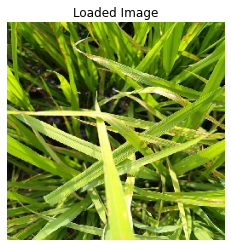

1/1 [==============================] - 1s 1s/step


Maximum Probability:  0.9999937
Classified: Blast 



-------------------Individual Probability--------------------------------

BACTERIAL LEAF BLIGHT : 0.0 %
BACTERIAL LEAF STREAK : 0.0 %
BACTERIAL PANICLE BLIGHT : 0.0 %
BLAST : 100.0 %
BROWN SPOT : 0.0 %
DEAD HEART : 0.0 %
DOWNY MILDEW : 0.0 %
HISPA : 0.0 %
NORMAL : 0.0 %
TUNGRO : 0.0 %


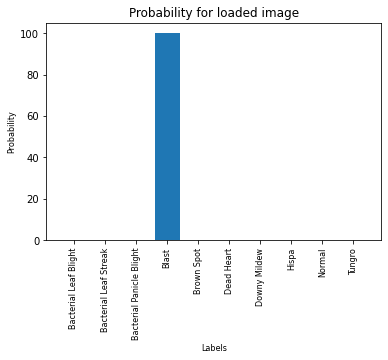

In [32]:
predict("./train_images/blast/100080.jpg")

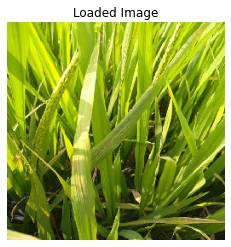

1/1 [==============================] - 0s 104ms/step


Maximum Probability:  0.9746737
Classified: Bacterial Leaf Streak 



-------------------Individual Probability--------------------------------

BACTERIAL LEAF BLIGHT : 0.04 %
BACTERIAL LEAF STREAK : 97.47 %
BACTERIAL PANICLE BLIGHT : 0.0 %
BLAST : 0.03 %
BROWN SPOT : 2.35 %
DEAD HEART : 0.04 %
DOWNY MILDEW : 0.04 %
HISPA : 0.01 %
NORMAL : 0.01 %
TUNGRO : 0.0 %


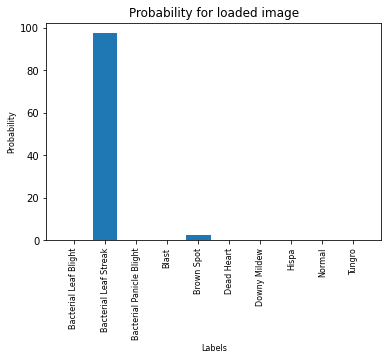

In [33]:
predict("./train_images/bacterial_leaf_streak/100299.jpg")

Found 9371 images belonging to 10 classes.
Model loaded successfully from: ./model_47-0.96.h5
1/1 [==============================] - 0s 65ms/step


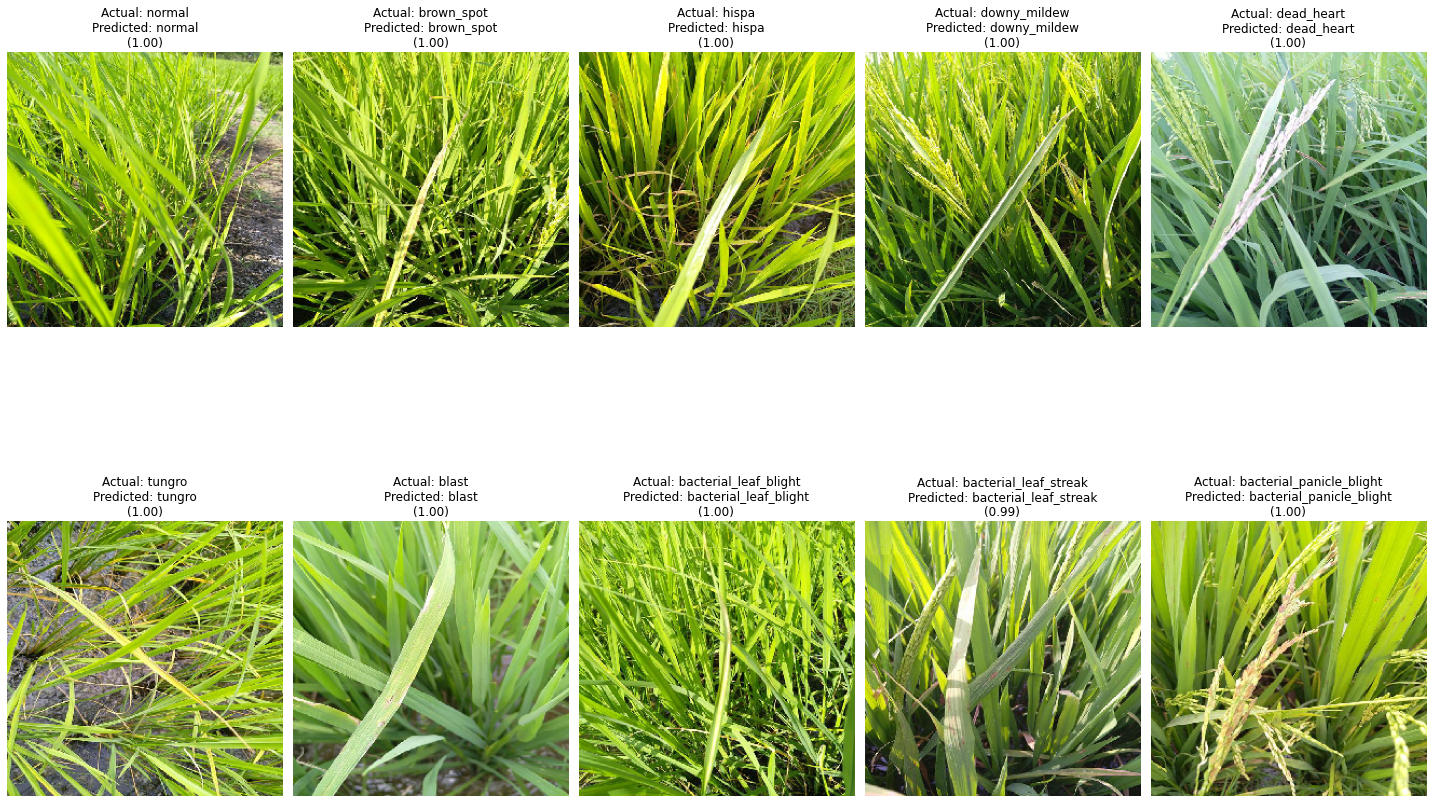

Predictions for the 28th image per class saved to predictions.csv.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_model_predict_and_visualize_28th_per_class(datagenerator, model_file, output_csv='predictions.csv'):
    # Check if the datagenerator is a dictionary or ImageDataGenerator object
    if isinstance(datagenerator, dict):
        class_indices = datagenerator['class_indices']
    else:
        class_indices = datagenerator.class_indices

    # Reverse the class_indices mapping to get class names
    class_names = {v: k for k, v in class_indices.items()}

    # Dictionary to keep track of selected images per class
    selected_images = {}
    image_counts = {class_id: 0 for class_id in class_names.keys()}

    # Load the model
    model = load_model(model_file)
    print(f"Model loaded successfully from: {model_file}")

    # List to store prediction results
    results = []

    # Set up the plot for displaying images
    plt.figure(figsize=(20, 15))  # Adjust size for 10 classes
    subplot_rows = (len(class_names) + 4) // 5  # Dynamically calculate rows for a 5-column layout

    # Iterate through the dataset to find the 28th image per class
    for i in range(len(datagenerator)):
        # Get a batch of images and labels
        if isinstance(datagenerator, dict):
            img_batch, true_labels = datagenerator['images'][i], datagenerator['labels'][i]
        else:
            img_batch, true_labels = datagenerator[i]

        for j in range(len(img_batch)):
            img = img_batch[j]
            true_label = np.argmax(true_labels[j])
            actual_class_name = class_names[true_label]

            # Increment count for this class
            image_counts[true_label] += 1

            # Check if the current count matches the 28th image for this class
            if image_counts[true_label] == 4:
                # Expand dimensions for prediction
                img_expanded = np.expand_dims(img, axis=0)
                prediction = model.predict(img_expanded)
                predicted_class = np.argmax(prediction)
                predicted_prob = prediction[0][predicted_class]
                predicted_class_name = class_names[predicted_class]

                # Store the prediction result
                results.append({
                    'Class': actual_class_name,
                    'Actual_Class': actual_class_name,
                    'Predicted_Class': predicted_class_name,
                    'Prediction_Probability': predicted_prob
                })

                # Plot the image with actual and predicted labels
                plt.subplot(subplot_rows, 5, len(selected_images) + 1)  # Adjust grid for 5 columns
                plt.imshow(image.array_to_img(img))
                plt.title(f"Actual: {actual_class_name}\nPredicted: {predicted_class_name}\n({predicted_prob:.2f})")
                plt.axis('off')

                # Save the image in the dictionary
                selected_images[true_label] = img

            # Stop if we have processed all classes with the 28th image
            if len(selected_images) == len(class_names):
                break

        # If all classes are processed, break from the outer loop
        if len(selected_images) == len(class_names):
            break

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Convert results to DataFrame and save as a CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"Predictions for the 28th image per class saved to {output_csv}.")

# Example usage: Create ImageDataGenerator
data_dir = "./train_images"  # Replace with your dataset path

datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.1)
datagenerator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use 'validation' for validation generator
)

model_file = r"./model_47-0.96.h5"  # Replace with your model file path

# Call the function
load_model_predict_and_visualize_28th_per_class(datagenerator, model_file)


Found 1036 images belonging to 10 classes.
1036/1036 [==============================] - 28s 26ms/step


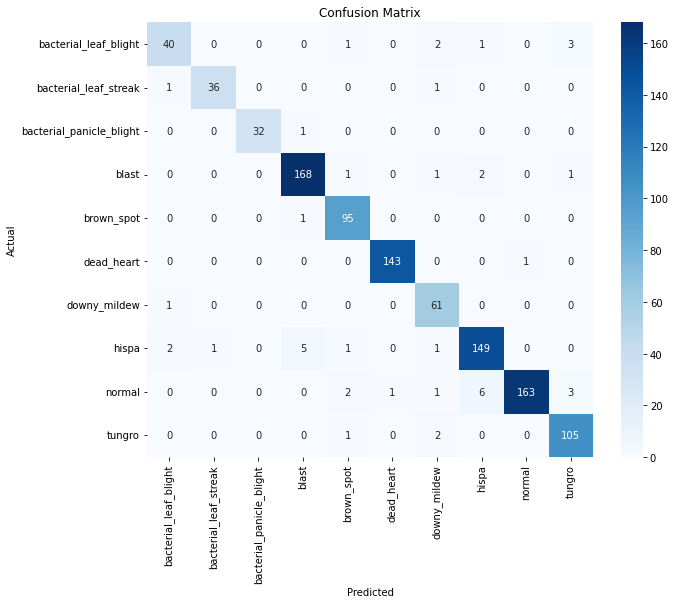


Classification Report:

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.91      0.85      0.88        47
   bacterial_leaf_streak       0.97      0.95      0.96        38
bacterial_panicle_blight       1.00      0.97      0.98        33
                   blast       0.96      0.97      0.97       173
              brown_spot       0.94      0.99      0.96        96
              dead_heart       0.99      0.99      0.99       144
            downy_mildew       0.88      0.98      0.93        62
                   hispa       0.94      0.94      0.94       159
                  normal       0.99      0.93      0.96       176
                  tungro       0.94      0.97      0.95       108

                accuracy                           0.96      1036
               macro avg       0.95      0.95      0.95      1036
            weighted avg       0.96      0.96      0.96      1036



In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Base Path for all files
data_dir = './train_images'

# Redefine the validation generator
valid_generator = ImageDataGenerator(rescale=1 / 255, validation_split=0.1).flow_from_directory(
    directory=data_dir,
    target_size=(256, 256),
    batch_size=1,  # Set batch size to 1 for consistent predictions
    subset='validation',
    shuffle=False   # Avoid shuffling for correct label alignment
)

# Load the best model
best_model = keras.models.load_model('./model_47-0.96.h5')  # Replace with your actual best model filename

# Generate predictions for all validation samples
predictions = best_model.predict(valid_generator, steps=valid_generator.n, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# True class labels
true_classes = valid_generator.classes

# Class labels
class_labels = list(valid_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualization of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Optional: Print Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
